In [1]:
import torch
from torch import nn 
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
#%matplotlib inline
import numpy as np
from utils import ops
import dataset_utils

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# Import and split dataset

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size =  16

In [3]:
all_images = torch.load('tensor_dataset/all_images.pt')
all_dnas = torch.load('tensor_dataset/all_dnas.pt')
all_labels = torch.load('tensor_dataset/all_labels.pt')
train_loc = torch.load('tensor_dataset/train_loc.pt')
val_seen_loc = torch.load('tensor_dataset/val_seen_loc.pt')
val_unseen_loc = torch.load('tensor_dataset/val_unseen_loc.pt')
test_seen_loc = torch.load('tensor_dataset/test_seen_loc.pt')
test_unseen_loc = torch.load('tensor_dataset/test_unseen_loc.pt')
species2genus = torch.load('tensor_dataset/species2genus.pt')
described_labels_train = torch.load('tensor_dataset/described_species_labels_train.pt')
described_labels_trainval= torch.load('tensor_dataset/described_species_labels_trainval.pt')

In [4]:
imsize = 64
class ImageDataset(Dataset):
        def __init__(self, imgs, targets):
            self.data = imgs
            self.targets = targets           
        def __getitem__(self, index):
            x = self.data[index]
            y = self.targets[index]
            return x, y
        
        def __len__(self):
            return len(self.data)
image_train = torch.clone(all_images[train_loc].data)
image_val = torch.clone(torch.cat((all_images[val_seen_loc],all_images[val_unseen_loc])).data)
image_test = torch.clone(torch.cat((all_images[test_seen_loc],all_images[test_unseen_loc])).data)
                         
labels_train = torch.clone(all_labels[train_loc].data)
labels_val = torch.clone(torch.cat((all_labels[val_seen_loc],all_labels[val_unseen_loc])).data)
labels_test = torch.clone(torch.cat((all_labels[test_seen_loc],all_labels[test_unseen_loc])).data)

train_d = ImageDataset(image_train,labels_train)
val_d = ImageDataset(image_val,labels_val)
train_val_d = ImageDataset(torch.cat((image_train,image_val)), torch.cat((labels_train,labels_val)))
test_d = ImageDataset(image_test,labels_test)

n_classes = all_labels.max()+1
print(f"n_classes={n_classes}")

n_classes=1050


In [5]:
print(f"n train images:{len(train_d)}")
print(f"n val images:{len(val_d)}")
print(f"n test images:{len(test_d)}")
print(f"n train+val images:{len(train_val_d)}")



n train images:13039
n val images:6955
n test images:12430
n train+val images:19994


In [6]:
train_loader = torch.utils.data.DataLoader(train_d, batch_size=batch_size,shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_d, batch_size=batch_size,shuffle=True, num_workers=2)
train_val_loader = torch.utils.data.DataLoader(train_val_d, batch_size=batch_size,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_d, batch_size=batch_size,shuffle=True, num_workers=2)
dataloaders = {"train":train_loader,"val":val_loader,"test":test_loader,'train_val':train_val_loader}
dataset_sizes = {'train': len(train_d), 'val':len(val_d),'test':len(test_d),'train_val':len(train_val_d)}
final_evaluation = False 
if final_evaluation:
    dataloaders['train'] = dataloaders['train_val']
    dataloaders['val'] = dataloaders['test']
    dataset_sizes['train'] = dataset_sizes['train_val']
    dataset_sizes['val'] = dataset_sizes['test']

In [7]:
print(dataset_sizes)

{'train': 13039, 'val': 6955, 'test': 12430, 'train_val': 19994}


# Initialize and train the models

In [8]:
import types
def define_modules(gan_config):
    layers = types.SimpleNamespace()
    if gan_config.apply_g_sn:
        layers.g_conv2d = ops.snconv2d
        layers.g_deconv2d = ops.sndeconv2d
        layers.g_linear = ops.snlinear
        layers.g_embedding = ops.sn_embedding
    else:
        layers.g_conv2d = ops.conv2d
        layers.g_deconv2d = ops.deconv2d
        layers.g_linear = ops.linear
        layers.g_embedding = ops.embedding

    if gan_config.apply_d_sn:
        layers.d_conv2d = ops.snconv2d
        layers.d_deconv2d = ops.sndeconv2d
        layers.d_linear = ops.snlinear
        layers.d_embedding = ops.sn_embedding
    else:
        layers.d_conv2d = ops.conv2d
        layers.d_deconv2d = ops.deconv2d
        layers.d_linear = ops.linear
        layers.d_embedding = ops.embedding

    if gan_config.g_cond_mtd == "cBN":
        layers.g_bn = ops.ConditionalBatchNorm2d
    elif gan_config.g_cond_mtd == "W/O":
        layers.g_bn = ops.batchnorm_2d
    else:
        raise NotImplementedError

    if not gan_config.apply_d_sn:
        layers.d_bn = ops.batchnorm_2d

    if gan_config.g_act_fn == "ReLU":
        layers.g_act_fn = nn.ReLU(inplace=True)
    elif gan_config.g_act_fn == "Leaky_ReLU":
        layers.g_act_fn = nn.LeakyReLU(negative_slope=0.1, inplace=True)
    elif gan_config.g_act_fn == "ELU":
        layers.g_act_fn = nn.ELU(alpha=1.0, inplace=True)
    elif gan_config.g_act_fn == "GELU":
        layers.g_act_fn = nn.GELU()
    elif gan_config.g_act_fn == "Auto":
        pass
    else:
        raise NotImplementedError

    if gan_config.d_act_fn == "ReLU":
        layers.d_act_fn = nn.ReLU(inplace=True)
    elif gan_config.d_act_fn == "Leaky_ReLU":
        layers.d_act_fn = nn.LeakyReLU(negative_slope=0.1, inplace=True)
    elif gan_config.d_act_fn == "ELU":
        layers.d_act_fn = nn.ELU(alpha=1.0, inplace=True)
    elif gan_config.d_act_fn == "GELU":
        layers.d_act_fn = nn.GELU()
    elif gan_config.g_act_fn == "Auto":
        pass
    else:
        raise NotImplementedError
    return layers
    
config = types.SimpleNamespace()
config.d_act_fn = "ReLU"
config.g_act_fn = "ReLU"
config.apply_d_sn= True
config.apply_g_sn= True
config.g_cond_mtd= "cBN"

l=define_modules(config)

In [9]:
import importlib
import modelReACGAN as m

importlib.reload(m)


discriminator = m.Discriminator(imsize,128,True,True,[1],"D2DCE",2048,True,num_classes=1050,d_init="ortho",d_depth=2,mixed_precision=True,MODULES=l)
discriminator.cuda()

generator = m.Generator(100,128,imsize,128,True,[4],"cBN",num_classes=1050,g_init="ortho",g_depth=2,mixed_precision=True,MODULES=l)
generator.cuda()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),lr=2e-4,betas=(0.0, 0.999))
#discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(),lr=1e-5)
#generator_optimizer = torch.optim.RMSprop(generator.parameters(),lr=1e-5)
generator_optimizer = torch.optim.Adam(generator.parameters(),lr=2e-5,betas=(0.0, 0.999))


n_params = dataset_utils.count_trainable_parameters(discriminator);
print(n_params)
n_params = dataset_utils.count_trainable_parameters(generator);
print(n_params)


writer = SummaryWriter()

84520322
55822084


In [10]:
class Data2DataCrossEntropyLoss(torch.nn.Module):
    def __init__(self, num_classes, temperature, m_p, device):
        super(Data2DataCrossEntropyLoss, self).__init__()
        self.num_classes = num_classes
        self.temperature = temperature
        self.m_p = m_p
        self.device = device
        self.calculate_similarity_matrix = self._calculate_similarity_matrix()
        self.cosine_similarity = torch.nn.CosineSimilarity(dim=-1)

    def _calculate_similarity_matrix(self):
        return self._cosine_simililarity_matrix

    def _cosine_simililarity_matrix(self, x, y):
        v = self.cosine_similarity(x.unsqueeze(1), y.unsqueeze(0))
        return v

    def make_index_matrix(self, labels):
        labels = labels.detach().cpu().numpy()
        num_samples = labels.shape[0]
        mask_multi, target = np.ones([self.num_classes, num_samples]), 0.0

        for c in range(self.num_classes):
            c_indices = np.where(labels==c)
            mask_multi[c, c_indices] = target
        return torch.tensor(mask_multi).type(torch.long).to(self.device)

    def remove_diag(self, M):
        h, w = M.shape
        assert h==w, "h and w should be same"
        mask = np.ones((h, w)) - np.eye(h)
        mask = torch.from_numpy(mask)
        mask = (mask).type(torch.bool).to(self.device)
        return M[mask].view(h, -1)

    def forward(self, embed, proxy, label, **_):
        # calculate similarities between sample embeddings
        sim_matrix = self.calculate_similarity_matrix(embed, embed) + self.m_p - 1
        # remove diagonal terms
        sim_matrix = self.remove_diag(sim_matrix/self.temperature)
        # for numerical stability
        sim_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = F.relu(sim_matrix) - sim_max.detach()

        # calculate similarities between sample embeddings and the corresponding proxies
        smp2proxy = self.cosine_similarity(embed, proxy)
        # make false negative removal
        removal_fn = self.remove_diag(self.make_index_matrix(label)[label])
        # apply the negative removal to the similarity matrix
        improved_sim_matrix = removal_fn*torch.exp(sim_matrix)

        # compute positive attraction term
        pos_attr = F.relu((self.m_p - smp2proxy)/self.temperature)
        # compute negative repulsion term
        neg_repul = torch.log(torch.exp(-pos_attr) + improved_sim_matrix.sum(dim=1))
        # compute data to data cross-entropy criterion
        criterion = pos_attr + neg_repul
        return criterion.mean()
def d_hinge(d_logit_real, d_logit_fake):
    return torch.mean(F.relu(1. - d_logit_real)) + torch.mean(F.relu(1. + d_logit_fake))
def g_hinge(d_logit_fake):
    return -torch.mean(d_logit_fake)

In [11]:
cond_loss = Data2DataCrossEntropyLoss(n_classes,0.5,0.98,device)
cond_lambda = 1 

In [12]:
torch.cuda.empty_cache()

In [13]:
#suffix = "PretrainedReACGAN18"
suffix = "PretrainedReACGAN18"
g_dict = torch.load('checkpoints/generator'+suffix)
generator.load_state_dict(g_dict['model_state_dict'])
d_dict = torch.load('checkpoints/discriminator'+suffix)
discriminator.load_state_dict(d_dict['model_state_dict'])
generator_optimizer.load_state_dict(g_dict['optimizer_state_dict'])
discriminator_optimizer.load_state_dict(d_dict['optimizer_state_dict'])
d_dict

{'epoch': 18,
 'model_state_dict': OrderedDict([('blocks.0.0.conv2d0.bias',
               tensor([-0.0587, -0.0444,  0.0039,  0.0258,  0.0009, -0.0132, -0.0562,  0.0006,
                        0.0151, -0.0037,  0.0493, -0.0103, -0.0220,  0.0145, -0.0043, -0.0489,
                        0.0293,  0.0359, -0.0004,  0.0143, -0.0325, -0.0022, -0.0576,  0.0225,
                       -0.0006, -0.0023,  0.0474,  0.0239, -0.1165, -0.0437, -0.0062, -0.0128,
                       -0.0107, -0.0070,  0.0285, -0.1108,  0.0029,  0.0027, -0.0032,  0.0029,
                        0.0044,  0.0281,  0.0127, -0.0432, -0.0126, -0.0051, -0.0234,  0.0186,
                       -0.0033,  0.0241, -0.0111, -0.0055, -0.0567,  0.0136, -0.1005,  0.0092,
                       -0.0767,  0.0563, -0.0127, -0.0079,  0.0048, -0.0015,  0.0063, -0.0736,
                       -0.0052, -0.0092, -0.0177, -0.0093,  0.0149, -0.0309,  0.0013, -0.0168,
                       -0.0076, -0.0066, -0.0018, -0.0008, -0.0160,  

/tmp/ipykernel_8024/3045532434.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  random_class = torch.tensor(described_labels_train[np.random.randint(0, len(described_labels_train), n_examples)],device=device)


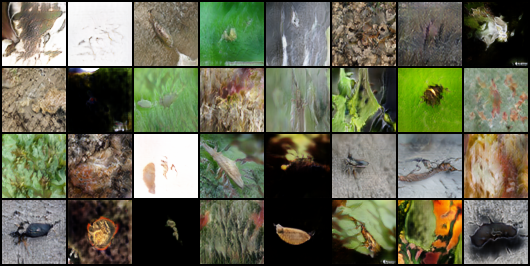

In [14]:
from torchvision.transforms import ToPILImage
from IPython.display import Image
import torchvision
n_examples = 32
with torch.no_grad():
    random_class = torch.tensor(described_labels_train[np.random.randint(0, len(described_labels_train), n_examples)],device=device)
    example_generated = generator(torch.randn(n_examples,100).to(device),random_class,eval = True)
    example_generated = dataset_utils.denorm(example_generated)
    p = torchvision.transforms.functional.to_pil_image(torchvision.utils.make_grid(example_generated))
    display(p)

In [15]:
example_generated.shape

torch.Size([32, 3, 64, 64])

In [16]:
torch.backends.cudnn.benchmark = True

In [21]:
fixed_latent = torch.randn(100,100).to(device)
import torchvision
from tqdm.notebook import tqdm
discriminator.train()
generator.train()
for epoch in range(13,20):
    for real_images, real_classes in tqdm(dataloaders['train']):
        real_images = real_images.to(device)
        real_classes = real_classes.to(device)
        #TRAIN DISCRIMINATOR
        for k in range(2):
            discriminator_optimizer.zero_grad()
            #use discriminator on real images
            real_dict = discriminator(real_images,real_classes)
            #use discriminator on fake images
            with torch.no_grad():
                random_classes = torch.tensor(described_species_labels[np.random.randint(0, len(described_species_labels), batch_size)],device=device)
                t = generator(torch.randn(batch_size,100).to(device),random_classes,eval = True)
            fake_dict = discriminator(t,random_classes)
            #Compute the two losses
            dis_acml_loss = d_hinge(real_dict["adv_output"], fake_dict["adv_output"])
            real_cond_loss = cond_loss(**real_dict)
            dis_acml_loss += cond_lambda * real_cond_loss
            dis_acml_loss.backward()
            discriminator_optimizer.step()


        
        #TRAIN GENERATOR
        generator_optimizer.zero_grad()
        random_classes = torch.tensor(described_species_labels[np.random.randint(0, len(described_species_labels), batch_size)],device=device)
        t = generator(torch.randn(batch_size,100).to(device),random_classes,eval = True)
        fake_dict = discriminator(t,random_classes)
        gen_acml_loss = g_hinge(fake_dict["adv_output"])
        fake_cond_loss = cond_loss(**fake_dict)
        gen_acml_loss += cond_lambda * fake_cond_loss
        gen_acml_loss.backward()
        generator_optimizer.step()
    
    print(f"disc loss={dis_acml_loss.item()}",end=',')
    print(f"gen loss={gen_acml_loss.item()}")
    with torch.no_grad():
        t = generator(fixed_latent,torch.tensor(np.arange(100)).to(device),eval = True)
    t = dataset_utils.denorm(t)
    p = torchvision.transforms.functional.to_pil_image(torchvision.utils.make_grid(t))
    p.save(f"generated/finetune25ex{epoch}.jpg")
        #torch.cuda.empty_cache()
        #loss_d, real_score, fake_score, class_accuracy_real, class_accuracy_fake

  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.19140625,gen loss=5.35546875


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.27734375,gen loss=5.33203125


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.552734375,gen loss=5.9765625


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.423828125,gen loss=5.2890625


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.806640625,gen loss=5.50390625


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.5078125,gen loss=5.57421875


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.697265625,gen loss=5.4609375


In [17]:
from extract_features import extract_image_features
(tf,tl),(vf,vl),(_,_) = extract_image_features(discriminator,device,save_to_disk=True,)#save_name_prefix="final_eval")

In [14]:
raise Exception
torch.save({
            'epoch':12,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': generator_optimizer.state_dict(),
            }, "checkpoints/generatorPretrained25FinetunedReACGAN12")
torch.save({
            'epoch': 12,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': discriminator_optimizer.state_dict(),
            }, "checkpoints/discriminatorPretrained25FinetunedReACGAN12")


# STO SCHIFO VA MESSO A POSTO E' SOLO PER IL REPORT

In [18]:

from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier 
#svm = LinearSVC(random_state=42)

# Make it an Multilabel classifier
#multilabel_classifier = MultiOutputClassifier(svm, n_jobs=-1)

# Fit the data to the Multilabel classifier
#svm = svm.fit(train_features, train_labels)

# Get predictions for test data
#y_test_pred = svm.predict(train_features)
clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(tf, tl)

In [20]:
train_predicted_labels = clf.predict(tf)
print(f"Training species accuracy:{np.count_nonzero(train_predicted_labels==tl)/len(tl)}")


Training species accuracy:0.9996932280082829


In [21]:
val_predicted_labels= clf.predict(vf)
print(f"Validation species accuracy:{np.count_nonzero(val_predicted_labels==vl)/len(vl)}")

Validation species accuracy:0.19942487419122934


In [22]:
from torchvision import transforms
import torchvision
df = pd.read_csv('final_dataset.csv',index_col=0)
tform = transforms.Compose([transforms.Resize((64,64)),transforms.PILToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder("image_dataset/",transform=tform)
species2genus = dataset_utils.species_label_to_genus_label(df,image_dataset)

In [23]:
#i = 100
import math
n_correct_genus = 0
for i in range(len(vl)):
    #label_best_specie = val_predicted_probs[i].argmax()
    label_best_specie = val_predicted_labels[i]
    
    #assert(int(val_predicted_labels[i])==int(val_predicted_probs[i].argmax()))
    genus_of_best_species = species2genus[label_best_specie.item()]
    #species_same_genus = [k for k,v in species2genus.items() if v == genus_of_best_species]
    #reduced_species = val_predicted_probs[i][species_same_genus]
    #normalized_reduced_species = reduced_species/(reduced_species.sum())
    
    real_genus = species2genus[vl[i]]
    predicted_genus = genus_of_best_species
    if real_genus == predicted_genus:
        n_correct_genus+=1
print(f"Validation genus accuracy: {n_correct_genus/len(vl)}")

Validation genus accuracy: 0.4905823148813803
